# Reinforcement Learning for CartPole
This project demonstrates how an AI can learn to balance a pole on a cart using reinforcement learning (RL). We'll use the CartPole environment from Gymnasium and the A2C algorithm from stable-baselines3.

## What is Reinforcement Learning?
RL is a type of machine learning where an agent learns to make decisions by interacting with an environment, aiming to maximize a reward.

## What is CartPole?
CartPole is a classic control problem where a pole is attached to a cart. The goal is to move the cart left or right to keep the pole balanced.

# Step 1: Importing Libraries
# This block imports all the necessary tools we need. Gymnasium provides the CartPole environment, Stable-Baselines3 gives us the PPO algorithm, Matplotlib helps us create real-time visualizations, and imageio lets us save the training as a video.

In [ ]:
!pip install gymnasium stable-baselines3 matplotlib imageio numpy

In [33]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import imageio
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from IPython.display import display, clear_output

# Step 2: Setting Up the Environment
# Here, we create the CartPole environment. The 'rgb_array' render mode allows us to capture each frame as an image, which we’ll use for both visualization and video creation.

In [34]:
# Create the training environment with rendering for animations
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Show what the AI observes (cart position, velocity, pole angle, angular velocity)
# and what actions it can take (move left or right)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


# Step 3: Initializing the PPO Model
# This block sets up the Proximal Policy Optimization (PPO) model, a reinforcement learning algorithm that’s great for this task. We use a simple multilayer perceptron (MLP) policy and connect it to our environment.

In [35]:
# Create the PPO model with a neural network policy
model = PPO('MlpPolicy', env, verbose=1)
# verbose=1 shows training progress (like rewards) in the notebook

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Step 4: Creating a Custom Visualization Callback
# This is where the magic happens! We define a custom callback class that runs during training. It captures each frame, updates a detailed plot with the cart and pole, and displays state information like the pole angle and cart position in real-time.

In [36]:
class VisualCallback(BaseCallback):
    def __init__(self, render_freq=50, verbose=0):
        super(VisualCallback, self).__init__(verbose)
        self.render_freq = render_freq  # Update visualization every 50 steps
        self.frames = []  # Store all frames for video
        self.fig, self.ax = plt.subplots(figsize=(12, 7))  # Large figure for clarity
        self.step_count = 0
        self.episode_reward = 0  # Track reward for current episode

    def _on_step(self) -> bool:
        self.step_count += 1
        # Get the current state (cart position, velocity, pole angle, angular velocity)
        state = self.locals['obs_tensor'][0].cpu().numpy()
        cart_pos = state[0]
        pole_angle = state[2]  # In radians
        reward = self.locals['rewards'][0]
        self.episode_reward += reward

        # Update visualization every render_freq steps
        if self.step_count % self.render_freq == 0:
            # Capture the current frame
            frame = self.training_env.render()
            if frame is not None:
                self.frames.append(frame)
            self.update_visualization(cart_pos, pole_angle, self.episode_reward)

        # Reset episode reward when episode ends
        if self.locals['dones'][0]:
            self.episode_reward = 0

        return True

    def update_visualization(self, cart_pos, pole_angle, episode_reward):
        self.ax.clear()

        # Draw the ground (a thick black line)
        self.ax.plot([-2.4, 2.4], [0, 0], 'k-', lw=3, label="Ground")

        # Draw the cart (a blue rectangle with wheels for realism)
        cart_width, cart_height = 0.6, 0.25
        cart_x = cart_pos - cart_width / 2
        cart = Rectangle((cart_x, 0), cart_width, cart_height, color='blue', ec='black', lw=2)
        self.ax.add_patch(cart)

        # Add wheels to the cart
        wheel_radius = 0.06
        wheel1 = Circle((cart_x + cart_width * 0.25, -wheel_radius), wheel_radius, color='black', ec='gray')
        wheel2 = Circle((cart_x + cart_width * 0.75, -wheel_radius), wheel_radius, color='black', ec='gray')
        self.ax.add_patch(wheel1)
        self.ax.add_patch(wheel2)

        # Draw the pole (a thick red line with a yellow tip for visibility)
        pole_length = 1.0
        pole_x_start = cart_pos
        pole_y_start = cart_height
        pole_x_end = pole_x_start + pole_length * np.sin(pole_angle)
        pole_y_end = pole_y_start + pole_length * np.cos(pole_angle)
        pole = plt.Line2D([pole_x_start, pole_x_end], [pole_y_start, pole_y_end],
                         color='red', lw=6, label="Pole")
        self.ax.add_line(pole)
        # Add a yellow tip to the pole
        pole_tip = Circle((pole_x_end, pole_y_end), 0.05, color='yellow')
        self.ax.add_patch(pole_tip)

        # Add state information as text
        info_text = (f"Step: {self.step_count}\n"
                    f"Cart Position: {cart_pos:.2f}\n"
                    f"Pole Angle: {np.degrees(pole_angle):.2f}°\n"
                    f"Episode Reward: {episode_reward:.1f}")
        self.ax.text(0.05, 0.95, info_text, transform=self.ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

        # Set plot limits and labels
        self.ax.set_xlim(-2.4, 2.4)
        self.ax.set_ylim(-0.5, 1.5)
        self.ax.set_xlabel("Cart Position (m)", fontsize=12)
        self.ax.set_ylabel("Height (m)", fontsize=12)
        self.ax.set_title("CartPole Training: Learning to Balance", fontsize=14)
        self.ax.grid(True, linestyle='--', alpha=0.7)
        self.ax.legend(loc='upper right')

        # Show the updated plot
        display(self.fig)
        clear_output(wait=True)

    def _on_training_end(self):
        # Save frames as an MP4 video
        if self.frames:
            imageio.mimsave('cartpole_training.mp4', self.frames, fps=60)
            print("Training video saved as 'cartpole_training.mp4'")
        plt.close(self.fig)

# Step 5: Training the Model with Visualization
# This block starts the training process. The custom callback we defined will handle the visualization and frame capture during the 10,000 timesteps.

In [37]:
# Create a callback for visualization
visual_callback = VisualCallback(render_freq=50)

# Create a separate environment for evaluation
eval_env = gym.make('CartPole-v1', render_mode='rgb_array')

# Set up evaluation callback to track performance
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                            log_path='./logs/', eval_freq=1000,
                            deterministic=True, render=False)

# Train the model
model.learn(total_timesteps=10000, callback=[eval_callback, visual_callback])

# Close the evaluation environment
eval_env.close()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 67.2     |
|    ep_rew_mean     | 67.2     |
| time/              |          |
|    fps             | 131      |
|    iterations      | 5        |
|    time_elapsed    | 77       |
|    total_timesteps | 10240    |
---------------------------------


Training video saved as 'cartpole_training.mp4'


# Step 6: Saving the Trained Model
# After training, we save the model to a file called 'ppo_cartpole.zip'. You can load this later to test or reuse the trained agent.

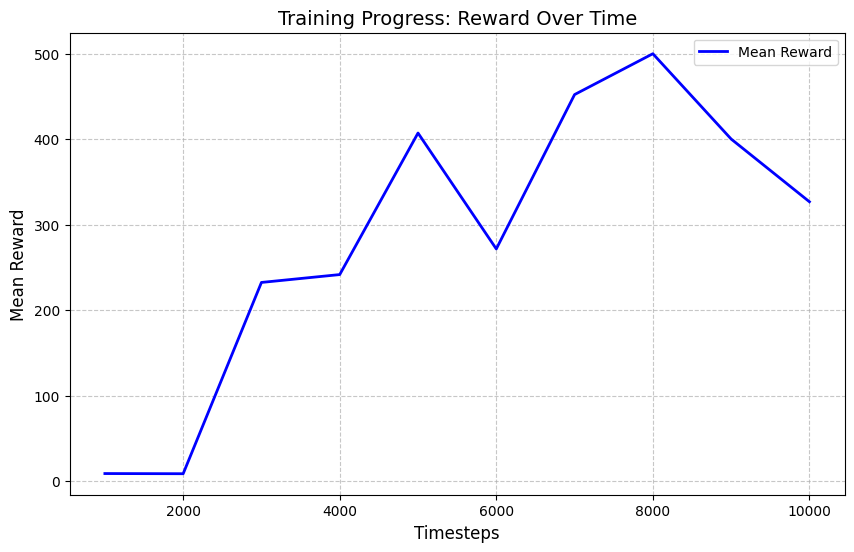

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Load evaluation results
results = np.load('./logs/evaluations.npz')
timesteps = results['timesteps'][:len(results['results'])]
mean_rewards = results['results'].mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mean_rewards, 'b-', lw=2, label='Mean Reward')
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Mean Reward", fontsize=12)
plt.title("Training Progress: Reward Over Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [39]:
# Save the trained model
model.save('ppo_cartpole')
print("Model saved as 'ppo_cartpole.zip'")

Model saved as 'ppo_cartpole.zip'


# Step 7: Testing the Trained Model
# This block loads the saved model and runs it in the environment to test how well it balances the pole. You can watch the result in real-time.

In [40]:
# Create a new environment for testing
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Load the saved model
model = PPO.load('ppo_cartpole')

# Reset the environment
reset_result = env.reset()
obs = reset_result[0] if isinstance(reset_result, tuple) else reset_result
frames = []
episode_reward = 0

# Run for 500 steps
fig, ax = plt.subplots(figsize=(12, 7))
for _ in range(500):
    action, _states = model.predict(obs, deterministic=True)
    step_result = env.step(action)
    obs = step_result[0]
    reward, terminated, truncated, info = step_result[1:]
    episode_reward += reward
    frame = env.render()
    if frame is not None:
        frames.append(frame)

    # Update visualization
    cart_pos = obs[0]
    pole_angle = obs[2]

    ax.clear()
    ax.plot([-2.4, 2.4], [0, 0], 'k-', lw=3, label="Ground")
    cart_width, cart_height = 0.6, 0.25
    cart_x = cart_pos - cart_width / 2
    cart = Rectangle((cart_x, 0), cart_width, cart_height, color='blue', ec='black', lw=2)
    ax.add_patch(cart)
    wheel_radius = 0.06
    wheel1 = Circle((cart_x + cart_width * 0.25, -wheel_radius), wheel_radius, color='black', ec='gray')
    wheel2 = Circle((cart_x + cart_width * 0.75, -wheel_radius), wheel_radius, color='black', ec='gray')
    ax.add_patch(wheel1)
    ax.add_patch(wheel2)
    pole_length = 1.0
    pole_x_start = cart_pos
    pole_y_start = cart_height
    pole_x_end = pole_x_start + pole_length * np.sin(pole_angle)
    pole_y_end = pole_y_start + pole_length * np.cos(pole_angle)
    pole = plt.Line2D([pole_x_start, pole_x_end], [pole_y_start, pole_y_end],
                     color='red', lw=6, label="Pole")
    ax.add_line(pole)
    pole_tip = Circle((pole_x_end, pole_y_end), 0.05, color='yellow')
    ax.add_patch(pole_tip)
    info_text = (f"Step: {_ + 1}\n"
                f"Cart Position: {cart_pos:.2f}\n"
                f"Pole Angle: {np.degrees(pole_angle):.2f}°\n"
                f"Episode Reward: {episode_reward:.1f}")
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))
    ax.set_xlim(-2.4, 2.4)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel("Cart Position (m)", fontsize=12)
    ax.set_ylabel("Height (m)", fontsize=12)
    ax.set_title("CartPole Testing: Trained Model", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    display(fig)
    clear_output(wait=True)

    if terminated or truncated:
        break

# Save test video
if frames:
    imageio.mimsave('cartpole_test.mp4', frames, fps=60)
    print("Test video saved as 'cartpole_test.mp4'")

# Close the environment and figure
env.close()
plt.close(fig)

Test video saved as 'cartpole_test.mp4'


# Step 8: Saving a Test Video
# Here, we save the frames from the test run as a separate MP4 video, so you can see how the trained agent performs.

In [41]:
from google.colab import files

# Download the model and videos
files.download('ppo_cartpole.zip')
files.download('cartpole_training.mp4')
files.download('cartpole_test.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 9: Cleaning Up
# Finally, we close the environment to free up resources.

In [42]:
env.close()